# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from tqdm import tqdm
# import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
# from src.helper_text import *
# from src.helper_langID import *
# from src.helper_translation import *
from src.helper_pred import *

# Prepare Data

## Load Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146485 entries, 0 to 146484
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        146485 non-null  int64 
 1   Title             146485 non-null  object
 2   Product Name      146485 non-null  object
 3   Length            146485 non-null  int64 
 4   Language          146485 non-null  object
 5   Title_Processed   146485 non-null  object
 6   Title_Translated  146485 non-null  object
 7   Title_Cleaned     146485 non-null  object
dtypes: int64(2), object(6)
memory usage: 8.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12114 entries, 0 to 12113
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        12114 non-null  int64 
 1   Title             12114 non-null  object
 2   Product Name      12114 non-null  object
 3   Length            1211

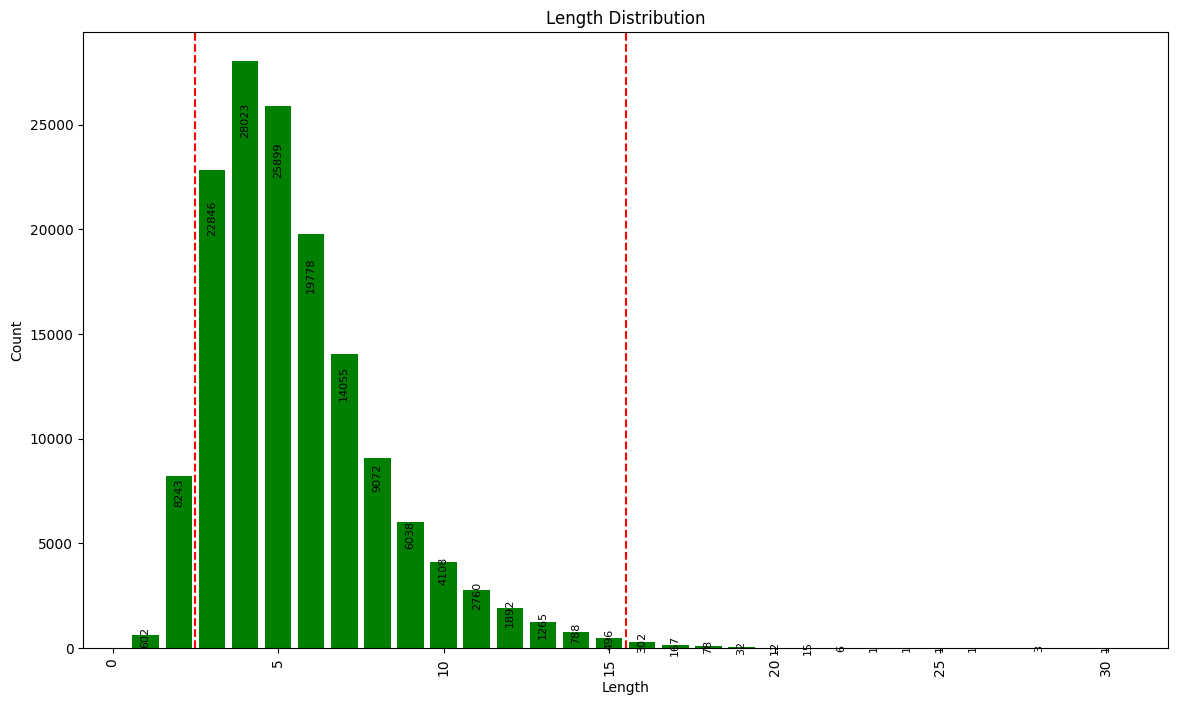

In [2]:
# excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_augmented.xlsx'
df_train = pd.read_excel(excel_file_train)
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test = pd.read_excel(excel_file_test)

print(df_train.info())
print(df_test.info())
hist_by_labels(df_train, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

## Remove short Titles

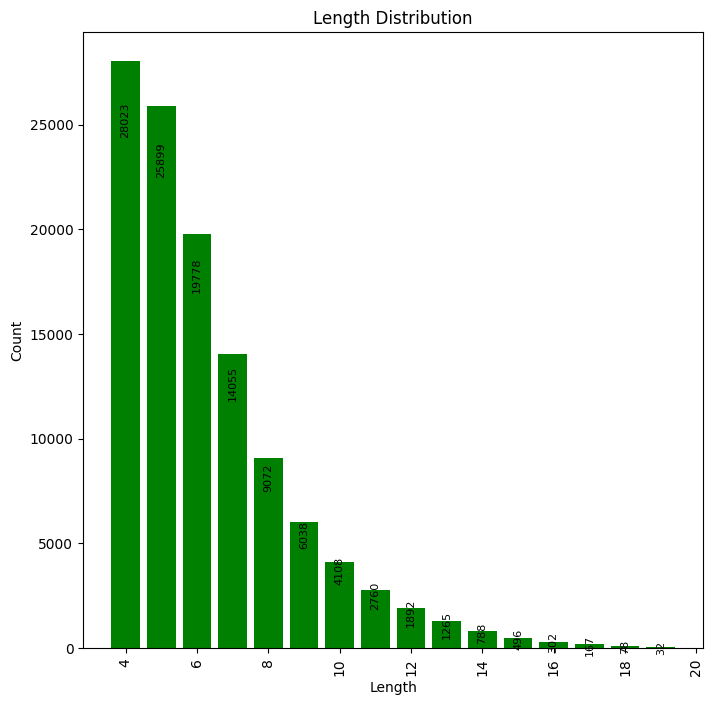

In [3]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_train['Length'] > 3) & (df_train['Length'] < 20)
df_train = df_train[mask]
hist_by_labels(df_train, 'Length', horizontal=True)

## Combine the long tail into Others

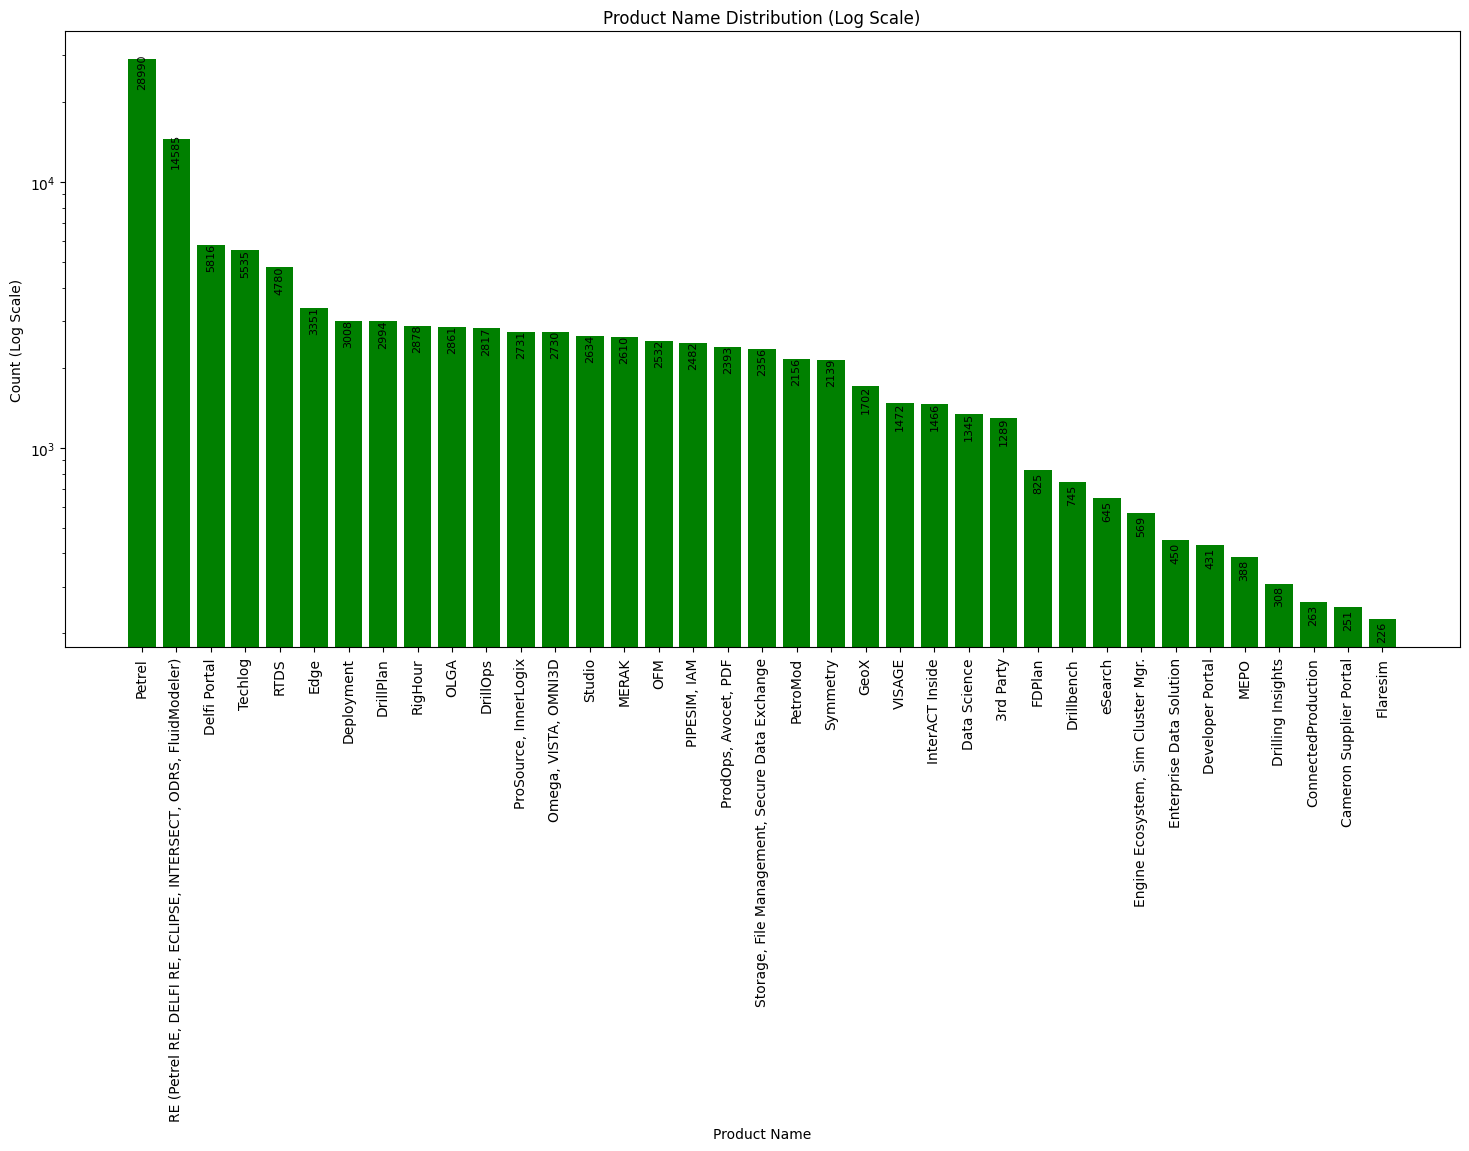

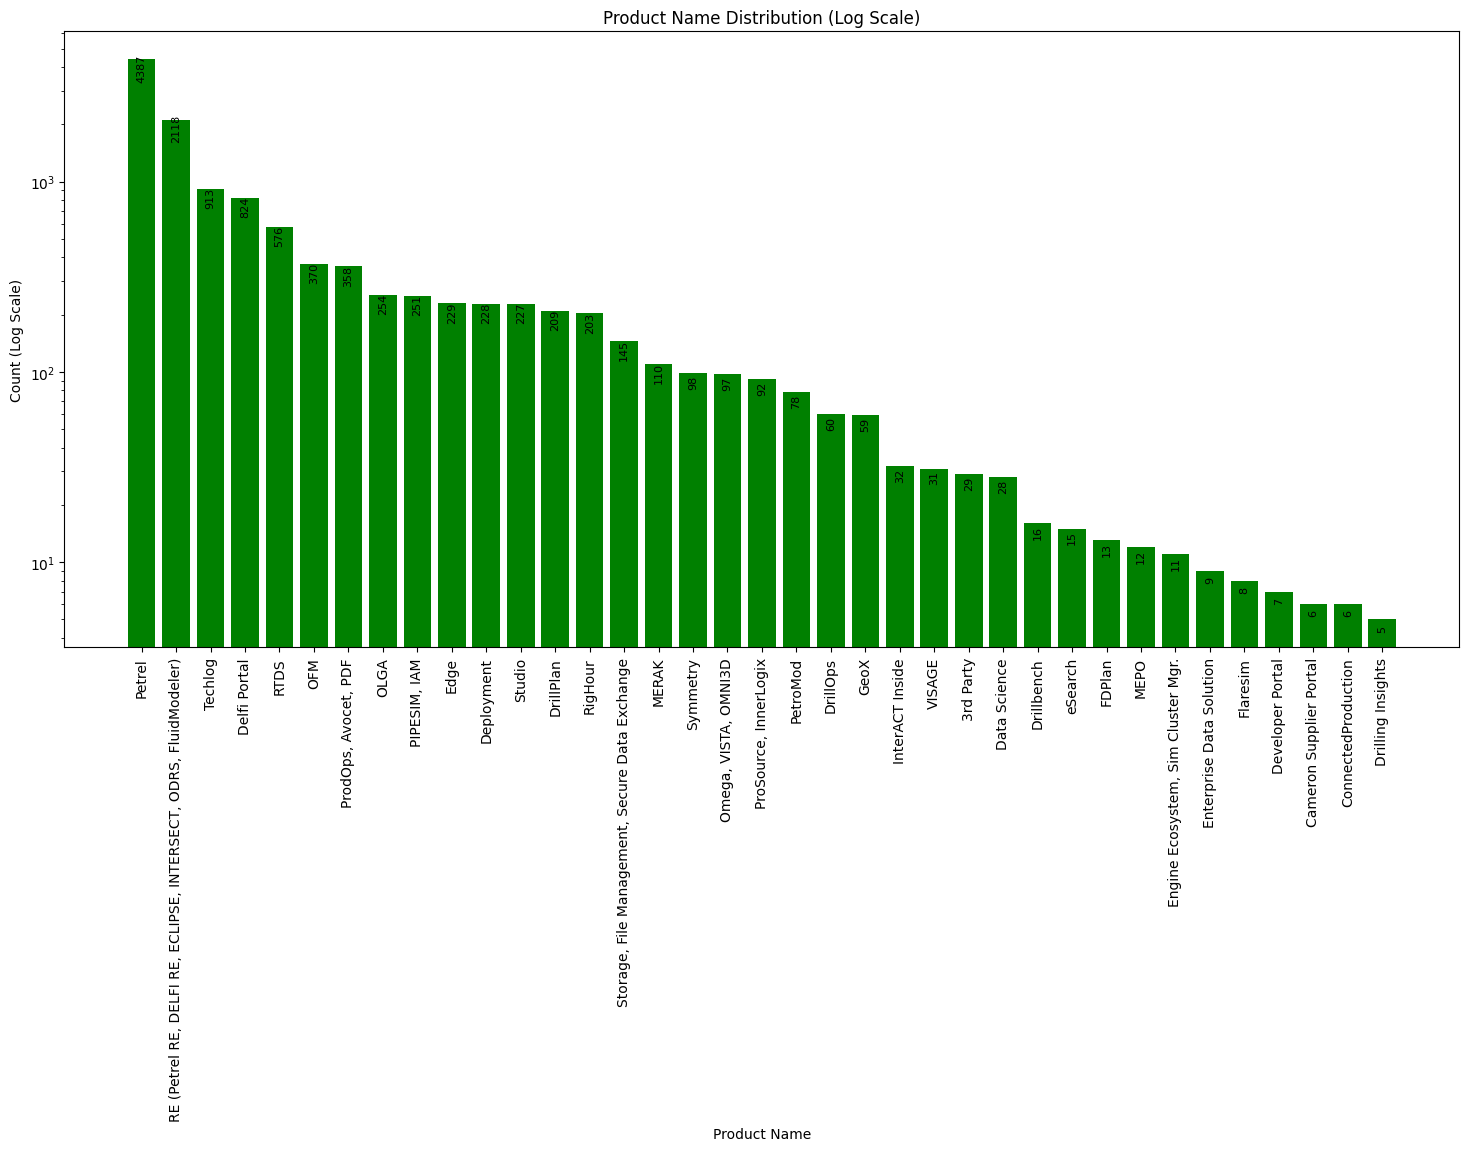

In [4]:
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_test, 'Product Name', top=None, log=True, horizontal=True)

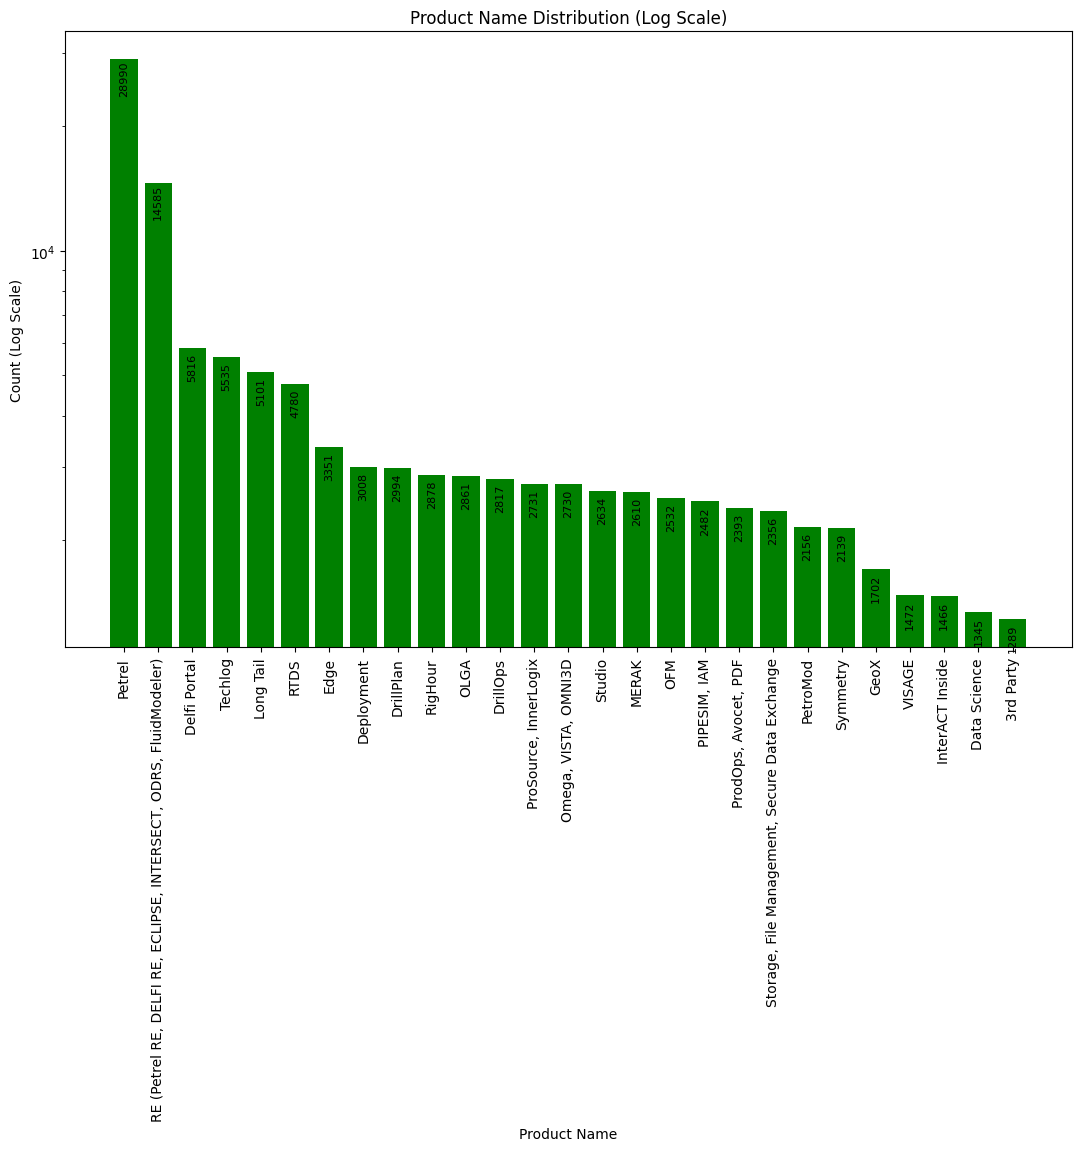

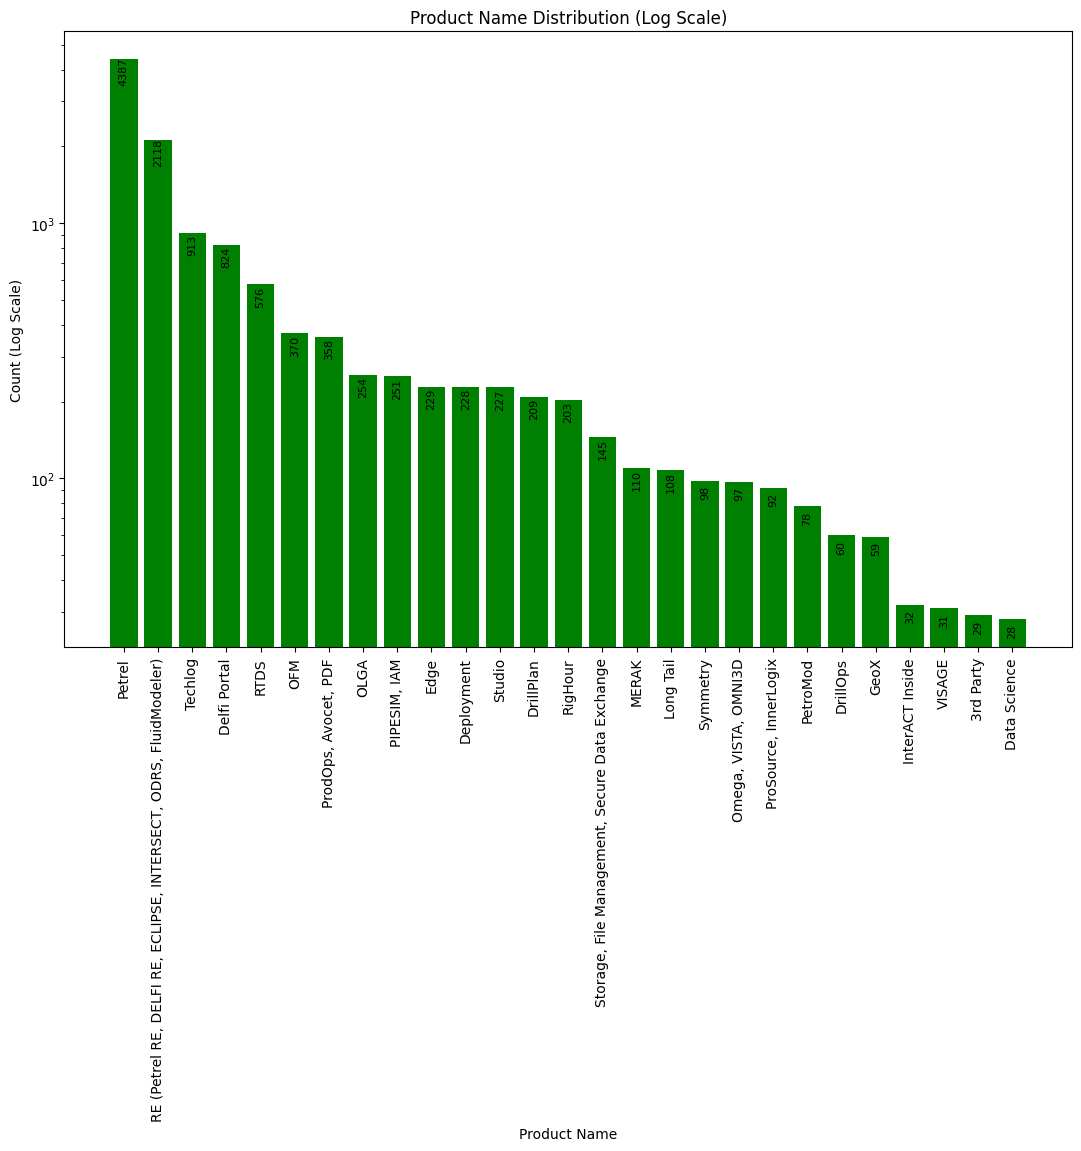

In [12]:
# Keep the top 50 products and combine the rest into 'Others'
cutoff = 1000

product_counts = df_train['Product Name'].value_counts()
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_train['Product Name'].isin(product_others)
df_train.loc[mask_others,'Product Name']='Long Tail'

mask_others = df_test['Product Name'].isin(product_others)
df_test.loc[mask_others,'Product Name']='Long Tail'

hist_by_labels(df_train, 'Product Name', log=True)
hist_by_labels(df_test, 'Product Name', log=True)

## Balance Train and Test Data

<class 'pandas.core.frame.DataFrame'>
Index: 79726 entries, 12726 to 125621
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        79726 non-null  int64 
 1   Title             79726 non-null  object
 2   Product Name      79726 non-null  object
 3   Length            79726 non-null  int64 
 4   Language          79726 non-null  object
 5   Title_Processed   79726 non-null  object
 6   Title_Translated  79726 non-null  object
 7   Title_Cleaned     79726 non-null  object
dtypes: int64(2), object(6)
memory usage: 5.5+ MB
None


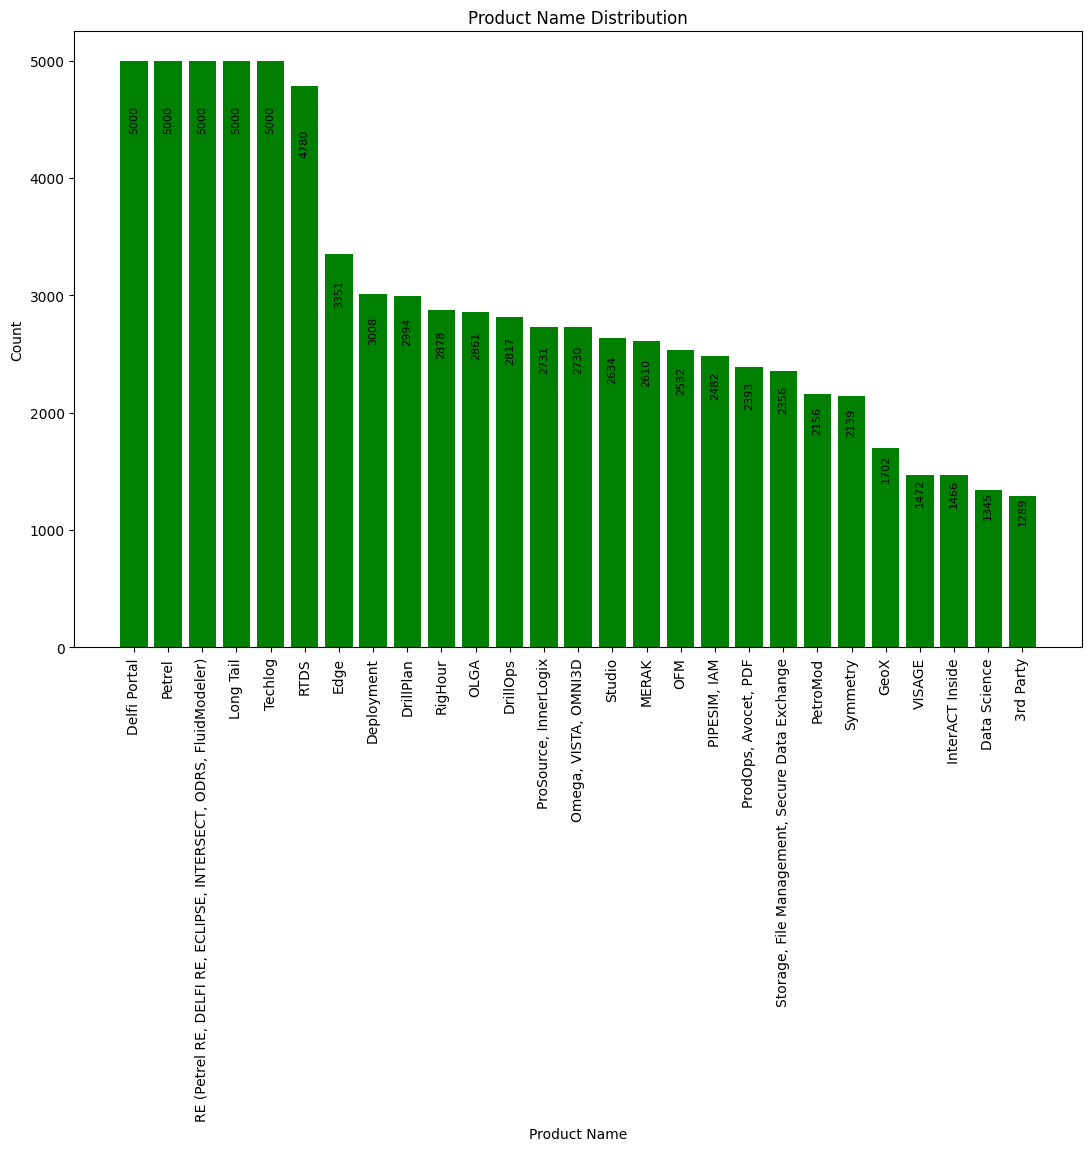

In [21]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
max_size = 5000

df_train_balanced = pd.DataFrame()

for product in df_train['Product Name'].unique():
    df_product = df_train[df_train['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_train_balanced = pd.concat([df_train_balanced, df_product_balanced])

print(df_train_balanced.info())

hist_by_labels(df_train_balanced, 'Product Name', log=False)

<class 'pandas.core.frame.DataFrame'>
Index: 4668 entries, 5271 to 12021
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        4668 non-null   int64 
 1   Title             4668 non-null   object
 2   Product Name      4668 non-null   object
 3   Length            4668 non-null   int64 
 4   Language          4668 non-null   object
 5   Title_Processed   4668 non-null   object
 6   Title_Translated  4668 non-null   object
 7   Title_Cleaned     4668 non-null   object
dtypes: int64(2), object(6)
memory usage: 328.2+ KB
None


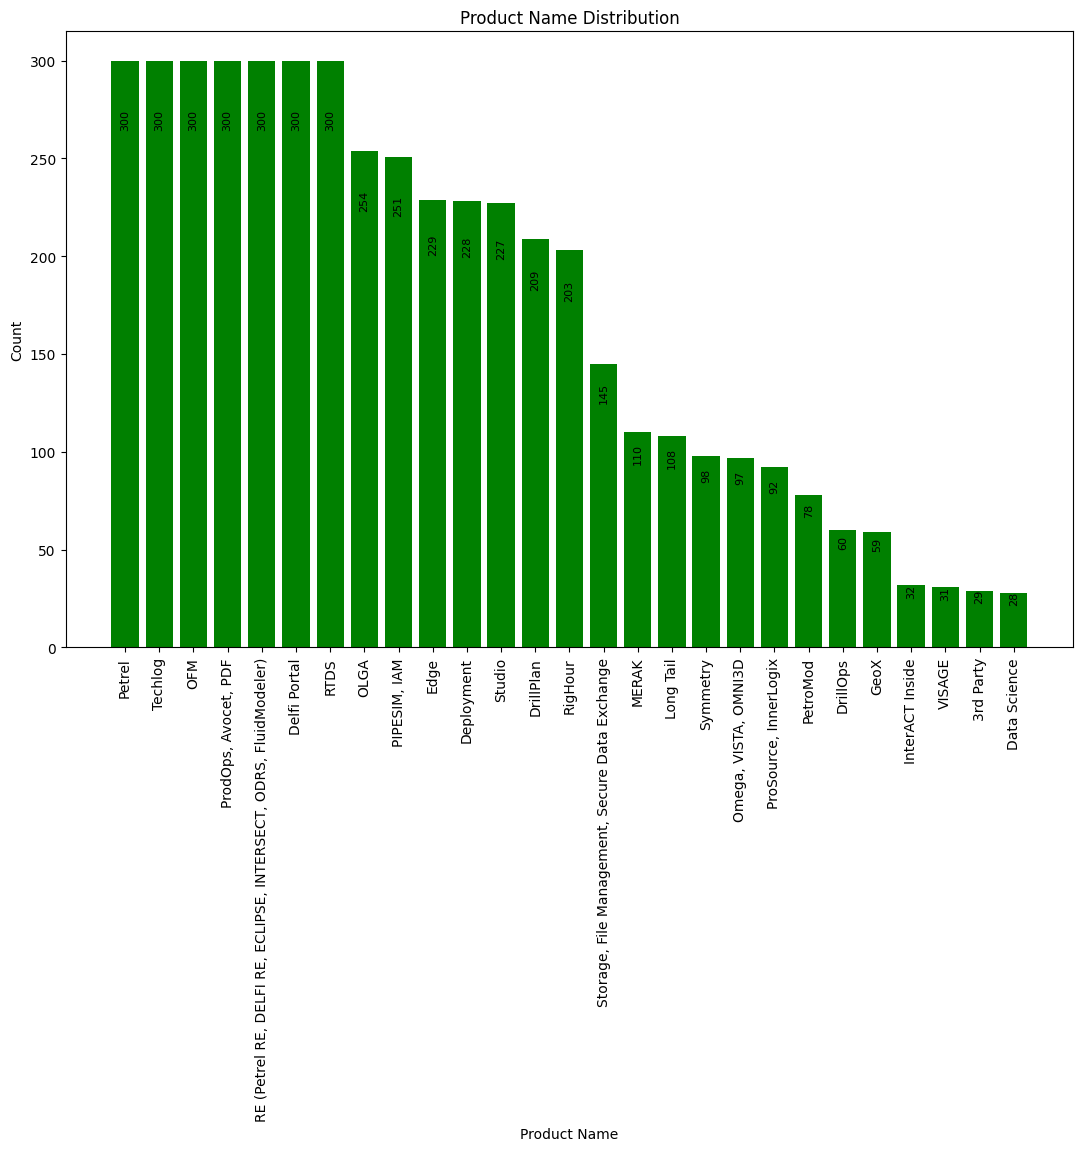

In [15]:
max_size = 300

df_test_balanced = pd.DataFrame()

for product in df_test['Product Name'].unique():
    df_product = df_test[df_test['Product Name'] == product]
    if df_product.shape[0] > max_size:
        df_product_balanced = df_product.sample(max_size).copy()
    else:
        df_product_balanced = df_product.copy()
    df_test_balanced = pd.concat([df_test_balanced, df_product_balanced])

print(df_test_balanced.info())


hist_by_labels(df_test_balanced, 'Product Name', log=False)

In [22]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

column_name = 'Title_Translated'

X = df_train[column_name]

vectorizer_countvec = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_countvec.fit(X)

vectorizer_tfidf = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf.fit(X)

X_train = df_train_balanced[column_name]
y_train = df_train_balanced['Product Name']

X_test = df_test_balanced[column_name]
y_test = df_test_balanced['Product Name']

X_train_countvec = vectorizer_countvec.transform(X_train)
X_test_countvec = vectorizer_countvec.transform(X_test)

X_train_tfidf = vectorizer_tfidf.transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# vectorizer = vectorizer_countvec
# X_train_encoded = X_train_countvec
# X_test_encoded = X_test_countvec

# vectorizer = vectorizer_tfidf
# X_train_encoded = X_train_tfidf
# X_test_encoded = X_test_tfidf

# Train Models

## Model Baseline - Cross Validation

In [9]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [10]:
models = {
    'SVC linear': SVC(kernel='linear'),
    'RandomForestClassifier': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'MultinomialNB': MultinomialNB(),
    # 'SVC rbf': SVC(kernel='rbf'),
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        # X_train_countvec,
        X_train_tfidf,
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.8539 by SGDClassifier.
Average score: 0.8556 by LogisticRegression.
Average score: 0.8856 by SVC linear.
Average score: 0.7962 by MultinomialNB.
Average score: 0.7978 by GradientBoostingClassifier.
Average score: 0.8716 by RandomForestClassifier.


In [ ]:
# Baseline Score(s) of each model are .... on augmented train dataset
# Average score: 0.8539 by SGDClassifier.
# Average score: 0.8556 by LogisticRegression.
# Average score: 0.8856 by SVC linear.
# Average score: 0.7962 by MultinomialNB.
# Average score: 0.7978 by GradientBoostingClassifier.
# Average score: 0.8716 by RandomForestClassifier.

## Hpyerparameter Tuning

## SGC Classifier

In [23]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_tfidf, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-21 19:12:31,860] A new study created in memory with name: no-name-792a8fc5-12a2-4034-8e17-65aa1125bbc9


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-21 19:12:41,756] Trial 5 finished with value: 0.8848807048970583 and parameters: {'loss': 'modified_huber', 'alpha': 4.022009551059225e-06, 'penalty': 'l2'}. Best is trial 5 with value: 0.8848807048970583.
[I 2023-10-21 19:12:42,689] Trial 3 finished with value: 0.07522062958093474 and parameters: {'loss': 'modified_huber', 'alpha': 14.209531823291487, 'penalty': 'l2'}. Best is trial 5 with value: 0.8848807048970583.
[I 2023-10-21 19:12:43,701] Trial 2 finished with value: 0.4651933105840868 and parameters: {'loss': 'modified_huber', 'alpha': 0.08556887272104699, 'penalty': 'l2'}. Best is trial 5 with value: 0.8848807048970583.
[I 2023-10-21 19:12:45,900] Trial 9 finished with value: 0.5387952126133445 and parameters: {'loss': 'log_loss', 'alpha': 0.0017800128052742, 'penalty': 'l2'}. Best is trial 5 with value: 0.8848807048970583.
[I 2023-10-21 19:12:46,073] Trial 0 finished with value: 0.05723379985374753 and parameters: {'loss': 'log_loss', 'alpha': 4.741195022365086, 'pe

                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.464     0.448     0.456        29
                                                    Data Science      0.750     0.643     0.692        28
                                                    Delfi Portal      0.577     0.687     0.627       300
                                                      Deployment      0.821     0.662     0.733       228
                                                        DrillOps      0.789     0.750     0.769        60
                                                       DrillPlan      0.837     0.833     0.835       209
                                                            Edge      0.996     0.974     0.985       229
                                                            GeoX      0.943     0.847     0.893        59
                                             

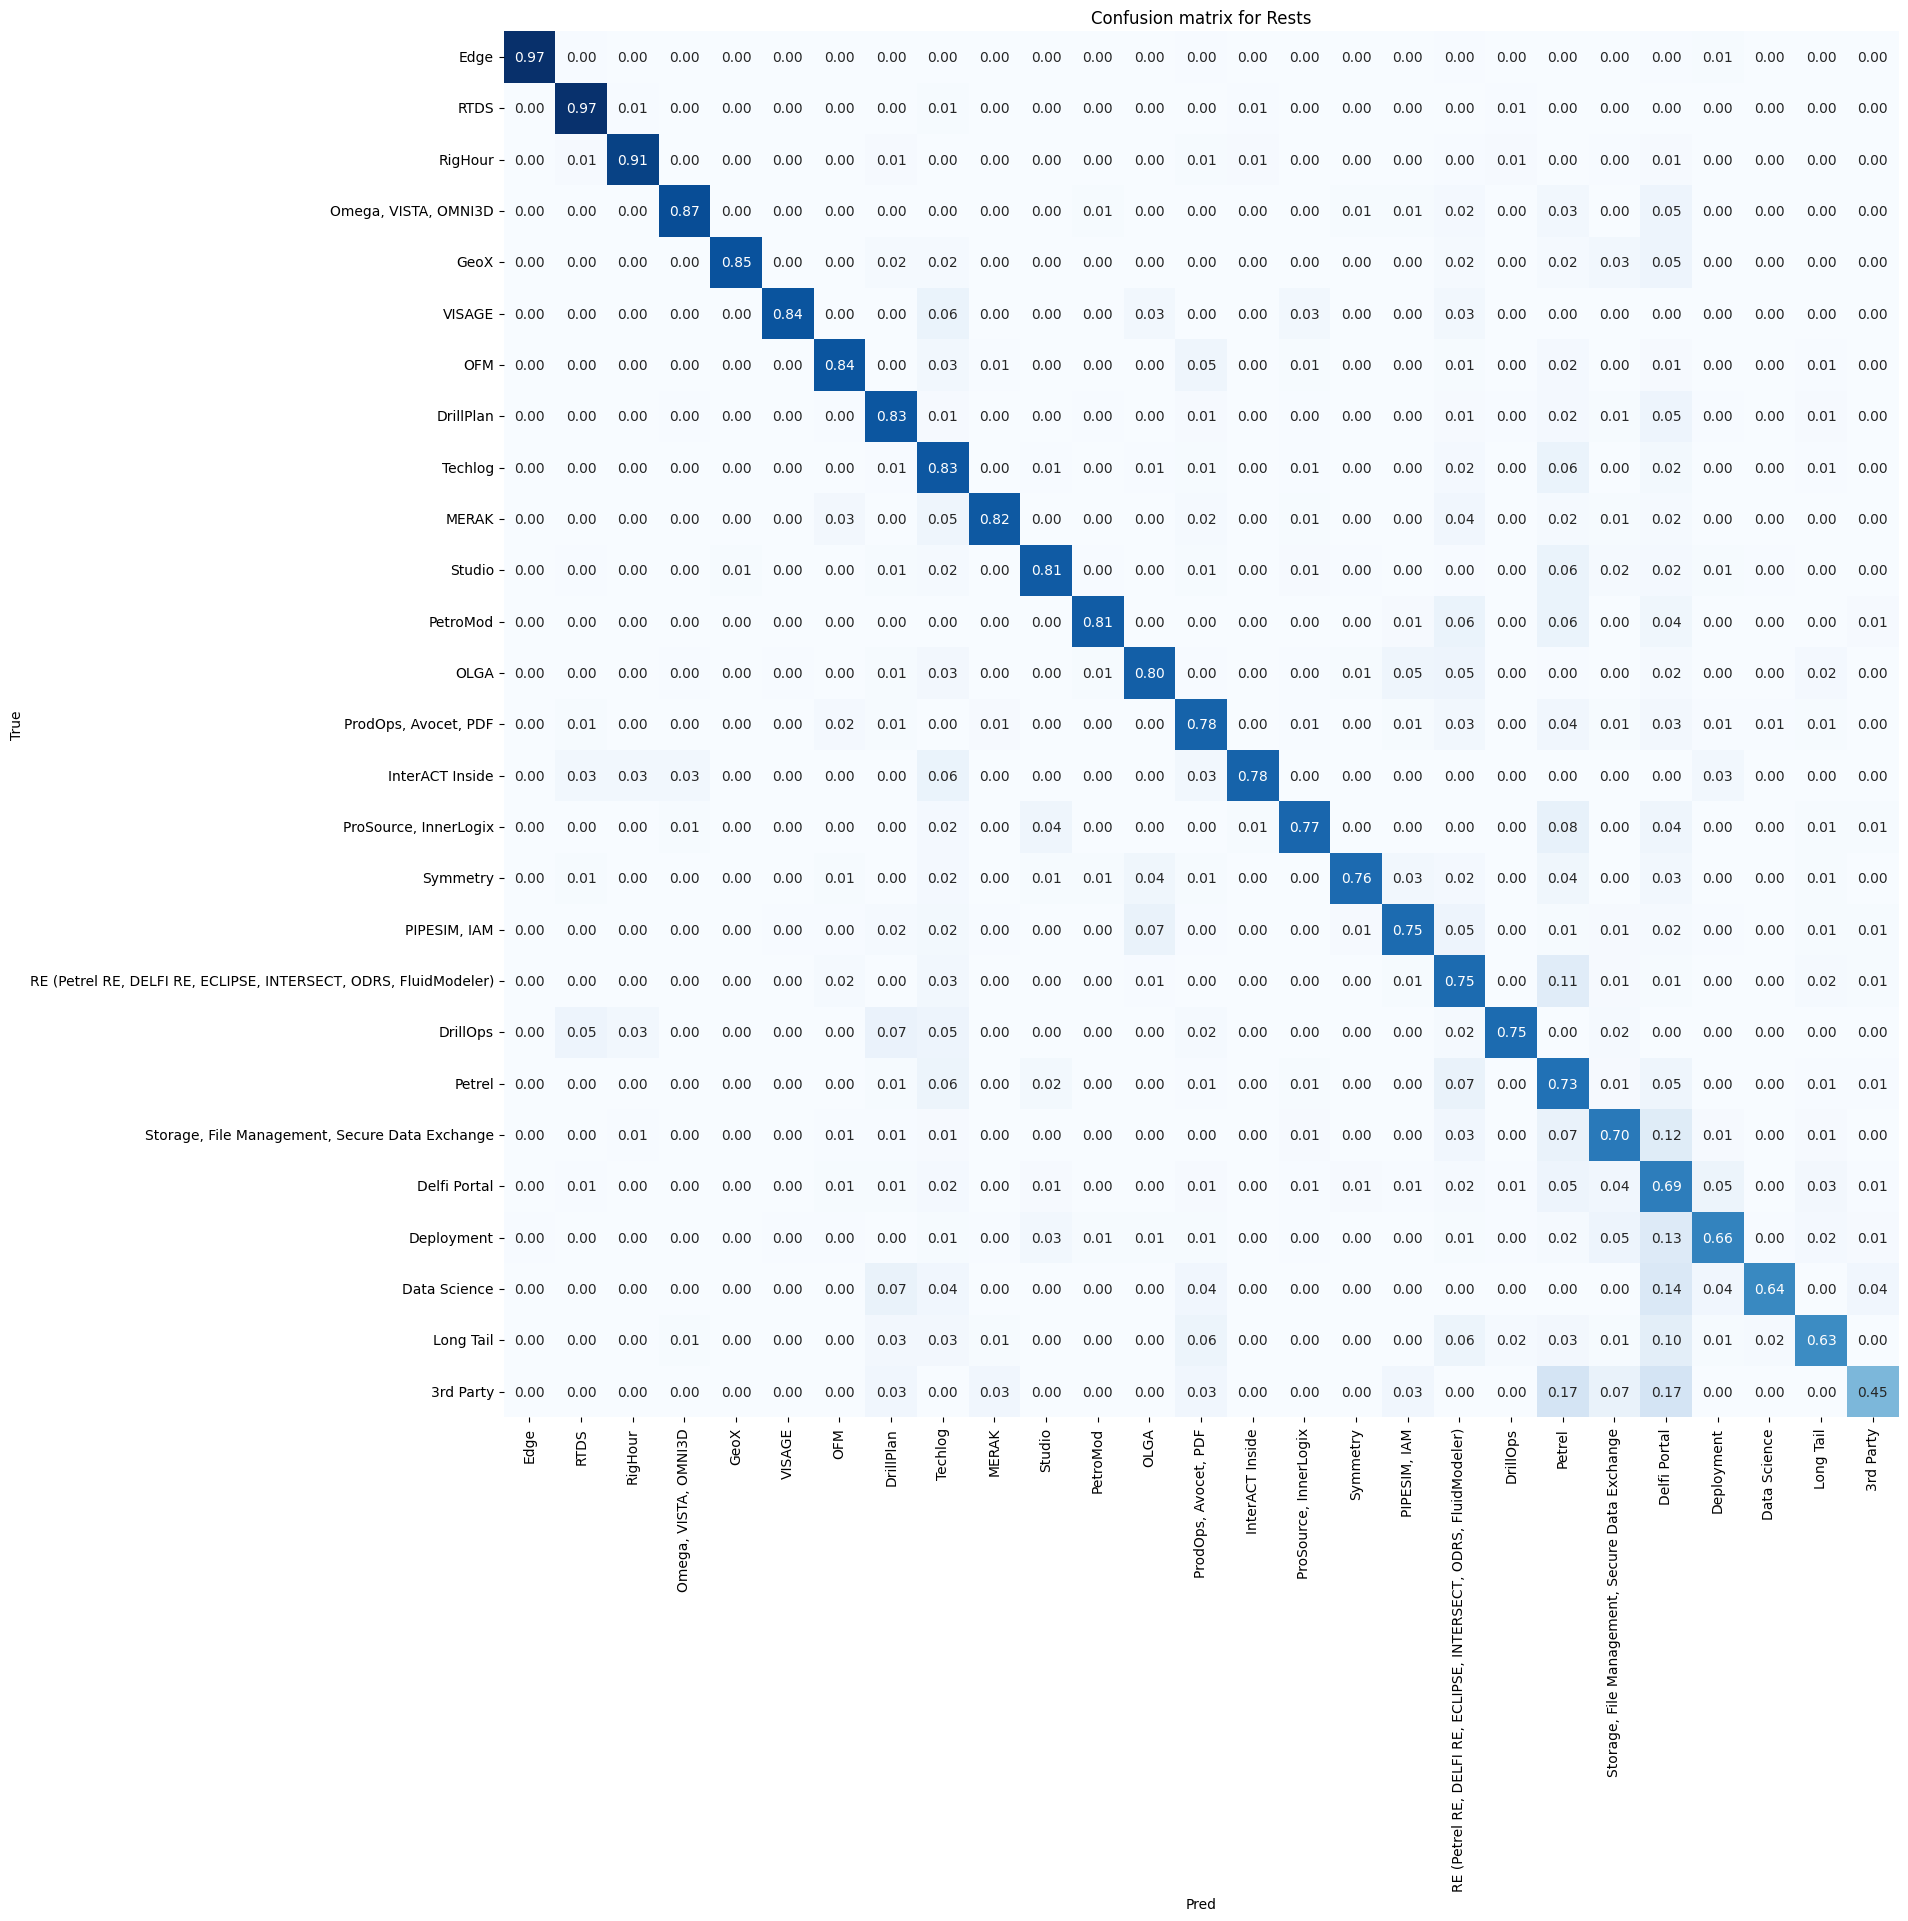

Accuracy of top 1 prediction is 0.795.
Accuracy of top 3 prediction is 0.907.
Accuracy of top 5 prediction is 0.936.


In [24]:
# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_tfidf)
# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))


## Logistic Classification

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'sag']),
        'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=25, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(**best_params)
best_model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# Create and train the best Logistic Regression model
model_logReg= LogisticRegression(max_iter=5000)
model_logReg.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer_countvec, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_countvec, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_countvec, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear

In [25]:
# user Optuna to tune the hyperparameters for SVC Linear

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', probability=True, **best_params)
best_model_svc_linear.fit(X_train_tfidf, y_train)


[I 2023-10-21 19:15:41,519] A new study created in memory with name: no-name-692e282f-9ec2-4f68-bfa7-2b6eb8bdd37a


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
best_model_svc_linear = SVC(kernel='linear', probability=True, **best_params)
best_model_svc_linear.fit(X_train_tfidf, y_train)

In [ ]:
# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## Voting model

In [ ]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('sgc_classifier', best_model_sgc),
    ('svc_linear', best_model_svc_linear),
    ('multinomialNB', best_model_multinomialNB)
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft', n_jobs=-1)

# Fit the voting classifier to the training data
voting.fit(X_train_tfidf, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [ ]:
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))